## ARIMA Prediction for Sales Forecasting

In [300]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
rcParams['figure.figsize'] = 10, 6

In [301]:
df = pd.read_csv('df.csv')

In [302]:
df.head()

,Date,Revenue
0,2019-01-03,797.688171
1,2019-01-04,3219.579102
2,2019-01-07,2700.857666
3,2019-01-15,8275.944336
4,2019-01-16,2600.349121


In [303]:
## Indexing the date

df.Date = pd.to_datetime(df.Date, infer_datetime_format= True)
df = df.set_index(['Date'])

df.head()

,Revenue
Date,
2019-01-03,797.688171
2019-01-04,3219.579102
2019-01-07,2700.857666
2019-01-15,8275.944336
2019-01-16,2600.349121


In [304]:
### We have to visually and statistically test for the stationarity. 
# A function has been prepared to graph the moving average and the moving standrad deviation and also perform a dfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(x):
    moving_average = x.rolling(window = 30).mean()
    moving_std  = x.rolling(window = 30).std()
    plot_orig = plt.plot(x, color = 'blue' , label = 'the original data set' )
    plot_mean = plt.plot(moving_average, color = 'red', label = 'moving average')
    plot_std = plt.plot(moving_std, color = 'orange', label = 'moving std')
    plt.legend(loc = 'best')
    plt.title('Line plot of the curve , rolling mean and rolling std')
    plt.show(block = False) 

    # dfuller
    

    print('results of the Dickey Fuller test:')
    dftest = adfuller(x.Revenue, autolag ='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test statistic','p-value','number of lags','Number of observations used'] )
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput) 
    


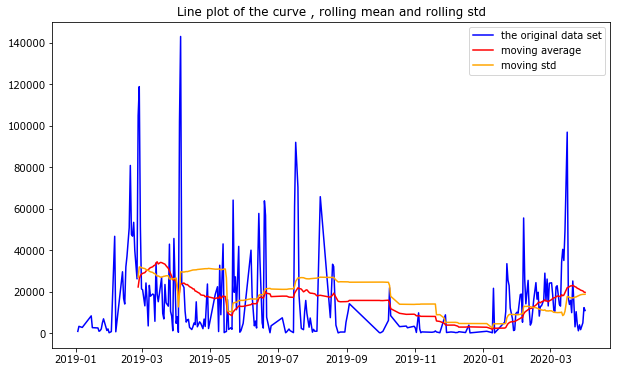

results of the Dickey Fuller test:
Test statistic                -9.192597e+00
p-value                        2.103645e-15
number of lags                 0.000000e+00
Number of observations used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [305]:

test_stationarity(df)

## Our data is not stationary, therefore, we have to apply some mathematical operations to make it more stationary. for that we will play around the log function

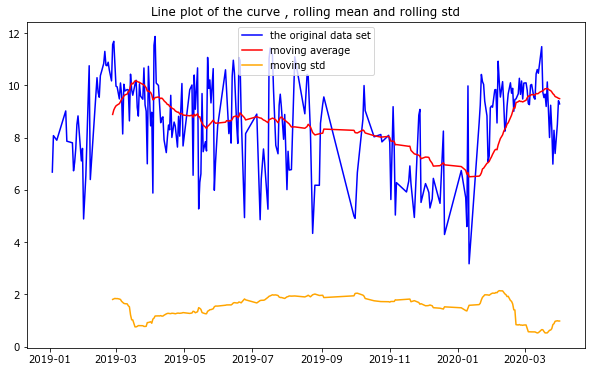

results of the Dickey Fuller test:
Test statistic                  -4.001955
p-value                          0.001400
number of lags                   4.000000
Number of observations used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [306]:
## Estimating the data as a trend

log_df = np.log(df)
test_stationarity(log_df)

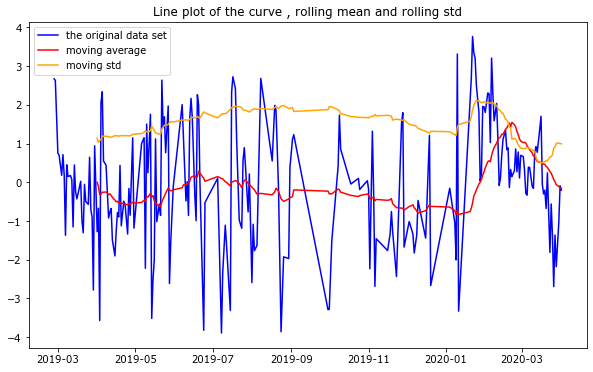

results of the Dickey Fuller test:
Test statistic                -7.555782e+00
p-value                        3.102342e-11
number of lags                 1.000000e+00
Number of observations used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


In [307]:
# opting for log(df) - moving average of log df

rolmean_log = log_df.rolling(window = 30).mean()
df_minus_mov = log_df - rolmean_log
df_minus_mov.dropna(inplace=True)
test_stationarity(df_minus_mov)

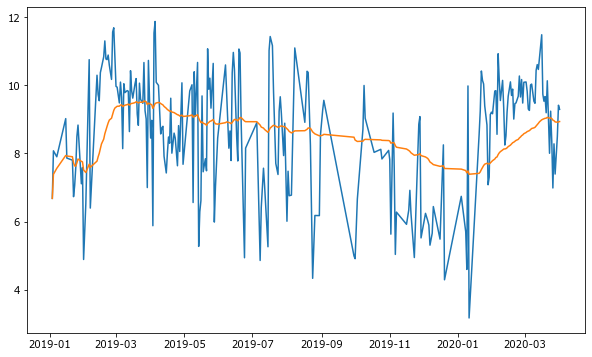

In [308]:
## playing with weighted average

df_weighted = log_df.ewm(halflife=30, min_periods=0, adjust= True).mean()
plt.plot(log_df)
plt.plot(df_weighted)

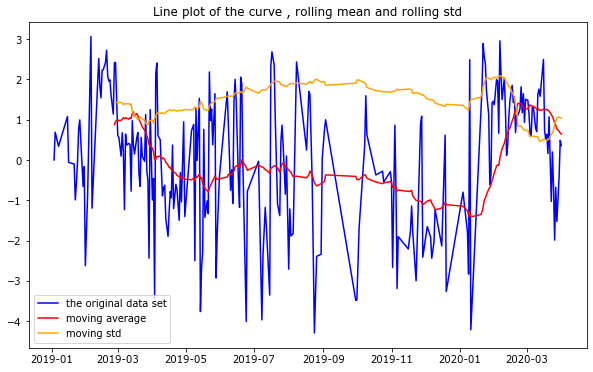

results of the Dickey Fuller test:
Test statistic                -7.080541e+00
p-value                        4.678910e-10
number of lags                 1.000000e+00
Number of observations used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


In [309]:
df_weighted_minus = log_df - df_weighted
test_stationarity(df_weighted_minus)

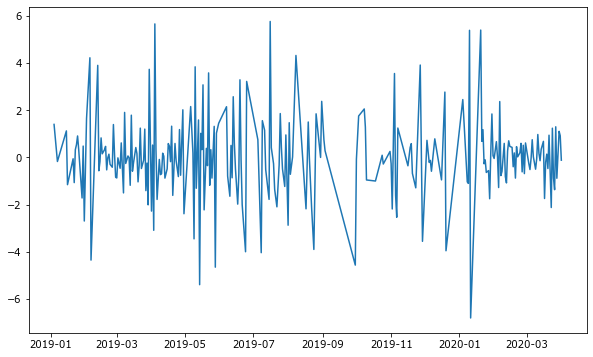

In [310]:
## using shift

df_shift = log_df - log_df.shift()
df_shift.dropna(inplace= True)
plt.plot(df_shift)

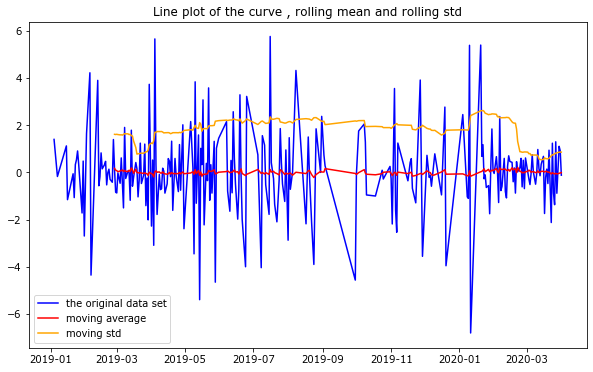

results of the Dickey Fuller test:
Test statistic                -1.020765e+01
p-value                        5.747918e-18
number of lags                 5.000000e+00
Number of observations used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


In [311]:
df_shift.dropna(inplace=True)
test_stationarity(df_shift)

In [312]:
## We can say that our data is almost stationary

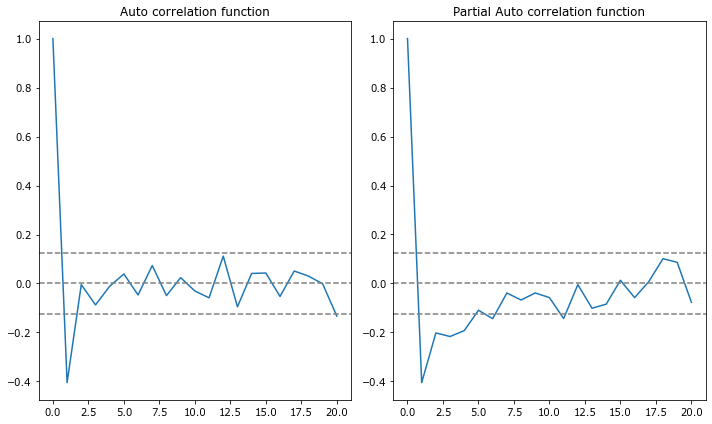

In [313]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_shift,nlags = 20)
lag_pacf = pacf(df_shift, nlags = 20, method= 'ols')

# plot acf

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0 , linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(df_shift)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(df_shift)), linestyle = '--', color = 'gray')
plt.title('Auto correlation function')

# plto pacf

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0 , linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(df_shift)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(df_shift)), linestyle = '--', color = 'gray')
plt.title('Partial Auto correlation function')
plt.tight_layout()


# p value and q value both equal to 1 in this case.

AR MODEL


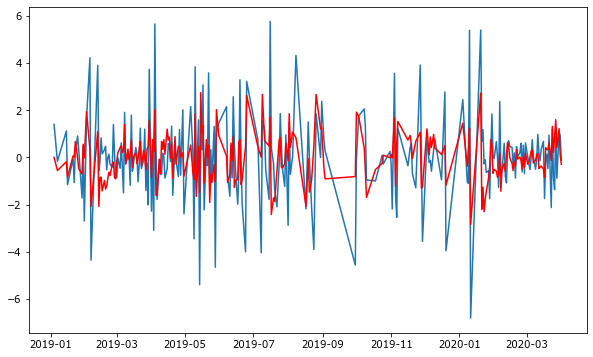

In [314]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings("ignore")
#AR Model
arima_model = ARIMA(log_df, order = (2, 1, 5))
results = arima_model.fit(disp = -1)
plt.plot(df_shift)
plt.plot(results.fittedvalues, color= 'red')
print('AR MODEL')

In [315]:
predictions_arima_diff = pd.Series(results.fittedvalues, copy = True)
print(predictions_arima_diff)

Date
2019-01-04    0.004582
2019-01-07   -0.557678
2019-01-15   -0.189576
2019-01-16   -0.831726
2019-01-21    0.061836
                ...   
2020-03-27    1.593588
2020-03-28    0.412656
2020-03-30    1.215094
2020-03-31    0.092661
2020-04-01   -0.300007
Length: 251, dtype: float64


In [316]:
predictions_arima_diff_cumsum = predictions_arima_diff.cumsum()
print(predictions_arima_diff_cumsum)

Date
2019-01-04    0.004582
2019-01-07   -0.553096
2019-01-15   -0.742672
2019-01-16   -1.574398
2019-01-21   -1.512562
                ...   
2020-03-27   -1.479610
2020-03-28   -1.066954
2020-03-30    0.148140
2020-03-31    0.240800
2020-04-01   -0.059206
Length: 251, dtype: float64


In [317]:

predictions_arima_log = pd.Series(log_df["Revenue"].iloc[0], index= log_df.index)
predictions_arima_log = predictions_arima_log.add(predictions_arima_diff_cumsum, fill_value= 0)
print(predictions_arima_log)


Date
2019-01-03    6.681718
2019-01-04    6.686300
2019-01-07    6.128622
2019-01-15    5.939045
2019-01-16    5.107320
                ...   
2020-03-27    5.202108
2020-03-28    5.614764
2020-03-30    6.829858
2020-03-31    6.922518
2020-04-01    6.622511
Length: 252, dtype: float64


In [318]:
predictions_arima = np.exp(predictions_arima_log)
predictions_arima


Date
2019-01-03     797.688171
2019-01-04     801.351749
2019-01-07     458.803270
2019-01-15     379.572424
2019-01-16     165.226907
                 ...     
2020-03-27     181.654691
2020-03-28     274.448479
2020-03-30     925.059175
2020-03-31    1014.872488
2020-04-01     751.830946
Length: 252, dtype: float64

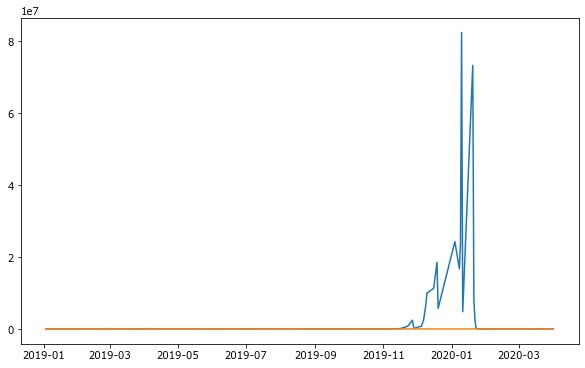

In [319]:
plt.plot(predictions_arima)
plt.plot(df)


## Our model was not able to predict the data correctly. As it is a 100% correct method, the data is in a small timespan (only 1 year). Therefore the model was not able
# to detect a trend (remember that arima needs seasonality)

## Classification using RFM 

RFM is a customer segmentation classification technique to identify the best customers in terms of an overall score, this score will be based on RFM : 


R : Recency (Time taken by the customer to buy another product , a cooldown)

F : Frequency (How many times the customer have bought something)

M : Monetary (How much money did he make to the company)

In [320]:
import datetime as dt


In [321]:
df1 = pd.read_csv('rfm.csv')
df1

,Pk Client,Client Name,Date,Revenue
0,5,CLIENT PASSAGER,2019-02-12,410.015137
1,5,CLIENT PASSAGER,2019-02-15,187.568497
2,5,CLIENT PASSAGER,2019-02-28,21.959999
3,5,CLIENT PASSAGER,2019-03-14,728.557007
4,5,CLIENT PASSAGER,2019-03-21,215.962006
...,...,...,...,...
9692,11633,STE TUNIS. ALIM. DU SAHEL STAS,2019-05-27,12362.093750
9693,11633,STE TUNIS. ALIM. DU SAHEL STAS,2019-06-07,16566.330080
9694,11633,STE TUNIS. ALIM. DU SAHEL STAS,2019-06-19,3911.607178
9695,11633,STE TUNIS. ALIM. DU SAHEL STAS,2020-03-06,5762.979004


In [322]:
# Checking for nulls ? 

df.isnull().values.any()


False

In [323]:
# Checking for type of variables 

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9697 entries, 0 to 9696
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pk Client    9697 non-null   int64  
 1   Client Name  9697 non-null   object 
 2   Date         9697 non-null   object 
 3   Revenue      9697 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 303.2+ KB


In [324]:
# Converting date

df1.Date = pd.to_datetime(df1.Date, infer_datetime_format= True)

# Converting Client name to string 

df1["Client Name"] = df1["Client Name"].astype('string')

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9697 entries, 0 to 9696
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Pk Client    9697 non-null   int64         
 1   Client Name  9697 non-null   string        
 2   Date         9697 non-null   datetime64[ns]
 3   Revenue      9697 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), string(1)
memory usage: 303.2 KB


In [325]:
# Getting the earliest and the latest date

print(df1.Date.min(), df1.Date.max())


2019-01-03 00:00:00 2020-04-01 00:00:00


In [326]:
# Getting number of days when a client purchased last time

last_day = dt.datetime(2020,4,1) #getting the last date as a variable

df1['hist']= last_day - df1.Date # Last date - date of purchase = days taken

df1['hist'].astype('timedelta64[D]') # We need it as a date type so that we can do date operations on it later on

df1['hist']=df1['hist'] / np.timedelta64(1, 'D') # getting the "days" part

df1.head()

,Pk Client,Client Name,Date,Revenue,hist
0,5,CLIENT PASSAGER,2019-02-12,410.015137,414.0
1,5,CLIENT PASSAGER,2019-02-15,187.568497,411.0
2,5,CLIENT PASSAGER,2019-02-28,21.959999,398.0
3,5,CLIENT PASSAGER,2019-03-14,728.557007,384.0
4,5,CLIENT PASSAGER,2019-03-21,215.962006,377.0


In [327]:
rfmTable = df1.groupby('Pk Client').agg({'hist': lambda x:x.min(),          # Recency
                                        'Pk Client': lambda x: len(x),      # Frequency
                                        'Revenue': lambda x: x.sum()})      # Monetary Value



In [328]:
rfmTable.rename(columns={'hist': 'recency', 
                         'Pk Client': 'frequency', 
                         'Revenue': 'monetary_value'}, inplace=True)

In [329]:
rfmTable.head()

,recency,frequency,monetary_value
Pk Client,,,
5,1.0,27,9701.100124
25,181.0,4,1279.367981
272,384.0,1,354.563202
312,0.0,2,724.964905
313,19.0,17,7705.875403


In [330]:
# We can double check for correctness of the table with a known client

df1[df1['Pk Client']==272]

,Pk Client,Client Name,Date,Revenue,hist
31,272,STE MED INDUSTRIE,2019-03-14,354.563202,384.0


In [331]:
# Dividing the RFM table into quarties for more convenience

quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      recency  frequency  monetary_value
0.25     19.0        2.0      321.285461
0.50     51.0        3.0      874.978333
0.75    260.0        7.0     2233.132042 <class 'pandas.core.frame.DataFrame'>


In [332]:
quartiles=quartiles.to_dict()  ## Convert it to a dictionairy to get the cut off values (the limits of the quartiles in this case)
quartiles

{'recency': {0.25: 19.0, 0.5: 51.0, 0.75: 260.0},
 'frequency': {0.25: 2.0, 0.5: 3.0, 0.75: 7.0},
 'monetary_value': {0.25: 321.28546144999996,
  0.5: 874.97833253,
  0.75: 2233.1320418}}

In [333]:
## Classifying Recency function by giving scores (in reverse because lower recency is better)

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    


In [334]:
## Classifying Monetary and frequency 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1    
    

In [335]:
# Putthing th scores in the RFM tables

rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

rfmSeg.head(3)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
Pk Client,,,,,,
5,1.0,27,9701.100124,1,1,1
25,181.0,4,1279.367981,3,2,2
272,384.0,1,354.563202,4,4,3


In [336]:
# To analyse better, we need to make 1 score instead of 3 for each cateogry , the first approach is to just merge the scores

# 1 , 1 , 1 will be 111 as a score

rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [337]:
rfmSeg.head()



,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
Pk Client,,,,,,,
5,1.0,27,9701.100124,1,1,1,111
25,181.0,4,1279.367981,3,2,2,322
272,384.0,1,354.563202,4,4,3,443
312,0.0,2,724.964905,1,4,3,143
313,19.0,17,7705.875403,1,1,1,111


In [338]:
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])



,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
Pk Client,,,,,,,
5913,8.0,17,51753.224182,1,1,1,111
4170,18.0,17,31367.197506,1,1,1,111
1500,14.0,8,30826.965210,1,1,1,111
7177,16.0,11,25994.820864,1,1,1,111
1077,11.0,20,19308.436145,1,1,1,111
...,...,...,...,...,...,...,...
8912,362.0,1,18.470400,4,4,4,444
3274,373.0,1,17.125000,4,4,4,444
2718,406.0,1,15.000000,4,4,4,444


In [339]:
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()


RFMClass
111    6705.460794
112    1636.356183
113     568.188778
121    6268.799182
122    1499.947534
123     623.104691
124     208.973942
131    3056.161085
132    1289.319141
133     615.565731
134     175.055370
141    6045.766358
142    1290.993868
143     528.225129
144     134.464643
211    5820.944930
212    1630.978027
213     667.942387
221    6021.055638
222    1373.234787
223     637.550372
224     220.500978
231    9084.594356
232    1370.355615
233     569.266204
234     188.829532
241    5615.875193
242    1373.473123
243     536.312609
244     155.369867
311    5302.371954
312    1660.683487
313     682.201292
321    4260.917095
322    1454.343208
323     617.717635
324     242.168460
331    7151.475584
332    1571.761089
333     559.691364
334     237.823950
341    4560.679548
342    1407.359025
343     504.272344
344     157.698897
411    2637.383980
412    2076.077589
413     363.615816
421    6023.515042
422    1291.387448
423     581.775714
424     202.839103
431

In [340]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
rfmSeg.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
Pk Client,,,,,,,,
5,1.0,27,9701.100124,1,1,1,111,3
25,181.0,4,1279.367981,3,2,2,322,7
272,384.0,1,354.563202,4,4,3,443,11
312,0.0,2,724.964905,1,4,3,143,8
313,19.0,17,7705.875403,1,1,1,111,3


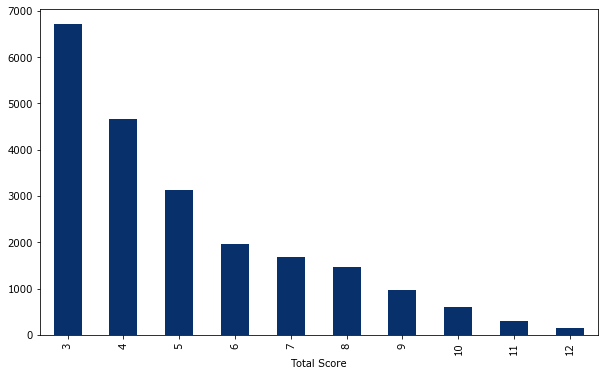

In [341]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')
plt.show()


<AxesSubplot:xlabel='Total Score'>

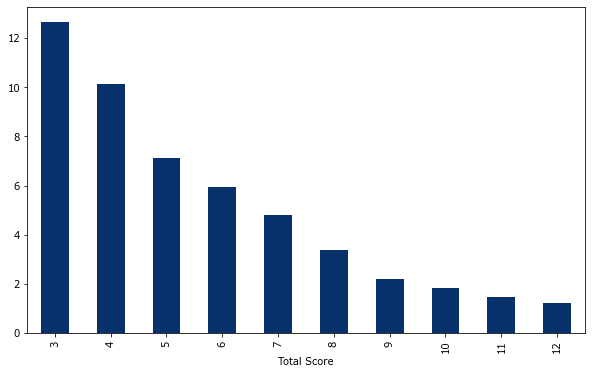

In [342]:
rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')


<AxesSubplot:xlabel='Total Score'>

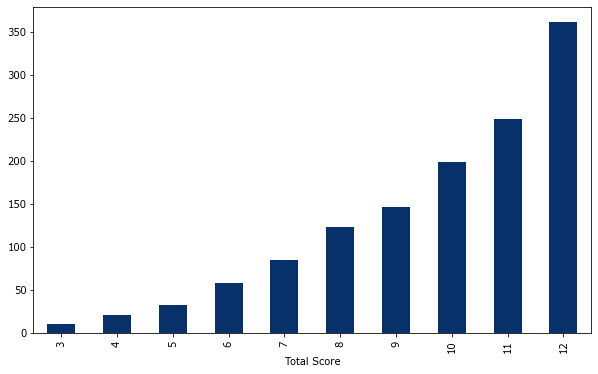

In [343]:
rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')


In [344]:
## Assigning loyalty levels to clients

Loyalty_level = ['Diamond Client', 'Gold Client', 'Silver Client', 'Standard Client']
Score_cuts = pd.qcut(rfmSeg['Total Score'], q = 4, labels = Loyalty_level)
rfmSeg['Loyalty'] = Score_cuts.values
rfmSeg = rfmSeg.reset_index()
rfmSeg.head()

,Pk Client,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,Loyalty
0,5,1.0,27,9701.100124,1,1,1,111,3,Diamond Client
1,25,181.0,4,1279.367981,3,2,2,322,7,Gold Client
2,272,384.0,1,354.563202,4,4,3,443,11,Standard Client
3,312,0.0,2,724.964905,1,4,3,143,8,Gold Client
4,313,19.0,17,7705.875403,1,1,1,111,3,Diamond Client


In [345]:
# Validating the diamond members

rfmSeg[rfmSeg.RFMClass == '111'].sort_values('monetary_value', ascending= False).head(10)

,Pk Client,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,Loyalty
1010,5913,8.0,17,51753.224182,1,1,1,111,3,Diamond Client
623,4170,18.0,17,31367.197506,1,1,1,111,3,Diamond Client
166,1500,14.0,8,30826.965210,1,1,1,111,3,Diamond Client
1248,7177,16.0,11,25994.820864,1,1,1,111,3,Diamond Client
114,1077,11.0,20,19308.436145,1,1,1,111,3,Diamond Client
1804,10047,14.0,18,18464.182953,1,1,1,111,3,Diamond Client
295,2414,2.0,8,16321.630325,1,1,1,111,3,Diamond Client
1673,9434,11.0,15,15877.859718,1,1,1,111,3,Diamond Client
167,1517,12.0,12,15281.984289,1,1,1,111,3,Diamond Client
1362,7782,11.0,11,14869.759551,1,1,1,111,3,Diamond Client


<AxesSubplot:xlabel='Total Score', ylabel='frequency'>

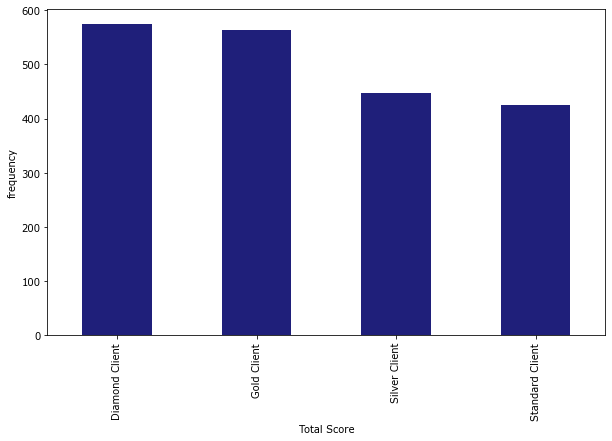

In [346]:
fig, ax = plt.subplots()

rfmSeg['Loyalty'].value_counts().plot(ax=ax, kind='bar', xlabel='Total Score', ylabel='frequency', color=(0.12157, 0.12157, 0.47843))

## Association Rule

We can try to identify which prodcuts are bought together to make strategic decisions


In [347]:
#!pip install plotly_express
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules

In [348]:
dataframe = pd.read_csv('df3.csv')
dataframe.head()

,Revenue,Prod Desc,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Pk Client,Abats de dinde frais,Blanquette de dinde frais,Cuisse de dinde frais,Cuisse dinde gros calibre frais,Escalope de dinde frais,Escalope dinde gms frais,Jambon de dinde,Salami superieur,Steak de dinde frais,Super salami dedinde special va
1,5,576.4140015,717.7409668,505.4029541,62.18700027,898.8959961,NaN,98.17599487,1084.613403,205.9360046,181.2289886
2,25,67.44000244,NaN,NaN,NaN,202.3200073,NaN,NaN,NaN,NaN,NaN
3,312,NaN,NaN,NaN,NaN,NaN,NaN,184.8182373,NaN,NaN,NaN
4,313,NaN,NaN,NaN,NaN,NaN,545.4879761,1134.865356,NaN,NaN,NaN


In [349]:
# Paste or type your script code here:




dataframe.columns = dataframe.iloc[0]

dataframe = dataframe.drop(axis = 0 , index=0)

dataframe

,Pk Client,Abats de dinde frais,Blanquette de dinde frais,Cuisse de dinde frais,Cuisse dinde gros calibre frais,Escalope de dinde frais,Escalope dinde gms frais,Jambon de dinde,Salami superieur,Steak de dinde frais,Super salami dedinde special va
1,5,576.4140015,717.7409668,505.4029541,62.18700027,898.8959961,NaN,98.17599487,1084.613403,205.9360046,181.2289886
2,25,67.44000244,NaN,NaN,NaN,202.3200073,NaN,NaN,NaN,NaN,NaN
3,312,NaN,NaN,NaN,NaN,NaN,NaN,184.8182373,NaN,NaN,NaN
4,313,NaN,NaN,NaN,NaN,NaN,545.4879761,1134.865356,NaN,NaN,NaN
5,314,NaN,NaN,NaN,NaN,NaN,1264.47998,566.7695923,NaN,NaN,36.68280029
...,...,...,...,...,...,...,...,...,...,...,...
1637,11052,NaN,NaN,NaN,NaN,NaN,NaN,1657.287354,NaN,NaN,31.04540062
1638,11073,NaN,NaN,NaN,NaN,110.7750015,NaN,NaN,NaN,NaN,NaN
1639,11083,NaN,NaN,NaN,NaN,NaN,NaN,95.57839966,NaN,NaN,NaN
1640,11601,107.7440033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.06199646,NaN


In [350]:
dataframe = dataframe.drop(dataframe.columns[0], axis = 1)

dataframe

,Abats de dinde frais,Blanquette de dinde frais,Cuisse de dinde frais,Cuisse dinde gros calibre frais,Escalope de dinde frais,Escalope dinde gms frais,Jambon de dinde,Salami superieur,Steak de dinde frais,Super salami dedinde special va
1,576.4140015,717.7409668,505.4029541,62.18700027,898.8959961,NaN,98.17599487,1084.613403,205.9360046,181.2289886
2,67.44000244,NaN,NaN,NaN,202.3200073,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,184.8182373,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,545.4879761,1134.865356,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1264.47998,566.7695923,NaN,NaN,36.68280029
...,...,...,...,...,...,...,...,...,...,...
1637,NaN,NaN,NaN,NaN,NaN,NaN,1657.287354,NaN,NaN,31.04540062
1638,NaN,NaN,NaN,NaN,110.7750015,NaN,NaN,NaN,NaN,NaN
1639,NaN,NaN,NaN,NaN,NaN,NaN,95.57839966,NaN,NaN,NaN
1640,107.7440033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.06199646,NaN


In [351]:
# fill Nan with 0

dataframe.fillna(0, inplace=True)

dataframe.head()


,Abats de dinde frais,Blanquette de dinde frais,Cuisse de dinde frais,Cuisse dinde gros calibre frais,Escalope de dinde frais,Escalope dinde gms frais,Jambon de dinde,Salami superieur,Steak de dinde frais,Super salami dedinde special va
1,576.4140015,717.7409668,505.4029541,62.18700027,898.8959961,0,98.17599487,1084.613403,205.9360046,181.2289886
2,67.44000244,0,0,0,202.3200073,0,0,0,0,0
3,0,0,0,0,0,0,184.8182373,0,0,0
4,0,0,0,0,0,545.4879761,1134.865356,0,0,0
5,0,0,0,0,0,1264.47998,566.7695923,0,0,36.68280029


In [352]:
mask = dataframe != 0

dataframe[mask] = 1

dataframe.head()

,Abats de dinde frais,Blanquette de dinde frais,Cuisse de dinde frais,Cuisse dinde gros calibre frais,Escalope de dinde frais,Escalope dinde gms frais,Jambon de dinde,Salami superieur,Steak de dinde frais,Super salami dedinde special va
1,1,1,1,1,1,0,1,1,1,1
2,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,1,0,0,0
5,0,0,0,0,0,1,1,0,0,1


In [353]:
dataframe = dataframe.astype(int)


In [354]:
dataframe

,Abats de dinde frais,Blanquette de dinde frais,Cuisse de dinde frais,Cuisse dinde gros calibre frais,Escalope de dinde frais,Escalope dinde gms frais,Jambon de dinde,Salami superieur,Steak de dinde frais,Super salami dedinde special va
1,1,1,1,1,1,0,1,1,1,1
2,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,1,0,0,0
5,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1637,0,0,0,0,0,0,1,0,0,1
1638,0,0,0,0,1,0,0,0,0,0
1639,0,0,0,0,0,0,1,0,0,0
1640,1,0,0,0,0,0,0,0,1,0


In [355]:
dataframe.to_csv('out.csv')


In [356]:
freq_items = apriori(dataframe, min_support = 0.2, use_colnames = True, verbose = 1)
freq_items.head()


Processing 6 combinations | Sampling itemset size 32


,support,itemsets
0,0.207800,(Abats de dinde frais)
1,0.275442,(Blanquette de dinde frais)
2,0.390615,(Cuisse de dinde frais)
3,0.218160,(Cuisse dinde gros calibre frais)
4,0.580134,(Escalope de dinde frais)


In [357]:
ar = association_rules(freq_items, metric = "confidence", min_threshold = 0.6)
ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Blanquette de dinde frais),(Escalope de dinde frais),0.275442,0.580134,0.207191,0.752212,1.296618,0.047398,1.694459
1,(Cuisse de dinde frais),(Escalope de dinde frais),0.390615,0.580134,0.325411,0.833073,1.436001,0.098802,2.515272
2,(Cuisse de dinde frais),(Salami superieur),0.390615,0.495430,0.242535,0.620905,1.253265,0.049013,1.330986
3,(Salami superieur),(Escalope de dinde frais),0.495430,0.580134,0.341865,0.690037,1.189444,0.054449,1.354567
4,"(Salami superieur, Escalope de dinde frais)",(Cuisse de dinde frais),0.341865,0.390615,0.217550,0.636364,1.629131,0.084013,1.675807
5,"(Salami superieur, Cuisse de dinde frais)",(Escalope de dinde frais),0.242535,0.580134,0.217550,0.896985,1.546168,0.076847,4.075772
6,"(Escalope de dinde frais, Cuisse de dinde frais)",(Salami superieur),0.325411,0.495430,0.217550,0.668539,1.349413,0.056332,1.522263


In [358]:
test = ar.sort_values('lift', ascending=False)
test

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,"(Salami superieur, Escalope de dinde frais)",(Cuisse de dinde frais),0.341865,0.390615,0.217550,0.636364,1.629131,0.084013,1.675807
5,"(Salami superieur, Cuisse de dinde frais)",(Escalope de dinde frais),0.242535,0.580134,0.217550,0.896985,1.546168,0.076847,4.075772
1,(Cuisse de dinde frais),(Escalope de dinde frais),0.390615,0.580134,0.325411,0.833073,1.436001,0.098802,2.515272
6,"(Escalope de dinde frais, Cuisse de dinde frais)",(Salami superieur),0.325411,0.495430,0.217550,0.668539,1.349413,0.056332,1.522263
0,(Blanquette de dinde frais),(Escalope de dinde frais),0.275442,0.580134,0.207191,0.752212,1.296618,0.047398,1.694459
2,(Cuisse de dinde frais),(Salami superieur),0.390615,0.495430,0.242535,0.620905,1.253265,0.049013,1.330986
3,(Salami superieur),(Escalope de dinde frais),0.495430,0.580134,0.341865,0.690037,1.189444,0.054449,1.354567


In [359]:
ar['lhs items'] = ar['antecedents'].apply(lambda x:len(x) )
ar[ar['lhs items']>0].sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lhs items
4,"(Salami superieur, Escalope de dinde frais)",(Cuisse de dinde frais),0.341865,0.390615,0.217550,0.636364,1.629131,0.084013,1.675807,2
5,"(Salami superieur, Cuisse de dinde frais)",(Escalope de dinde frais),0.242535,0.580134,0.217550,0.896985,1.546168,0.076847,4.075772,2
1,(Cuisse de dinde frais),(Escalope de dinde frais),0.390615,0.580134,0.325411,0.833073,1.436001,0.098802,2.515272,1
6,"(Escalope de dinde frais, Cuisse de dinde frais)",(Salami superieur),0.325411,0.495430,0.217550,0.668539,1.349413,0.056332,1.522263,2
0,(Blanquette de dinde frais),(Escalope de dinde frais),0.275442,0.580134,0.207191,0.752212,1.296618,0.047398,1.694459,1


In [360]:
ar["lhs items"].unique()

array([1, 2], dtype=int64)

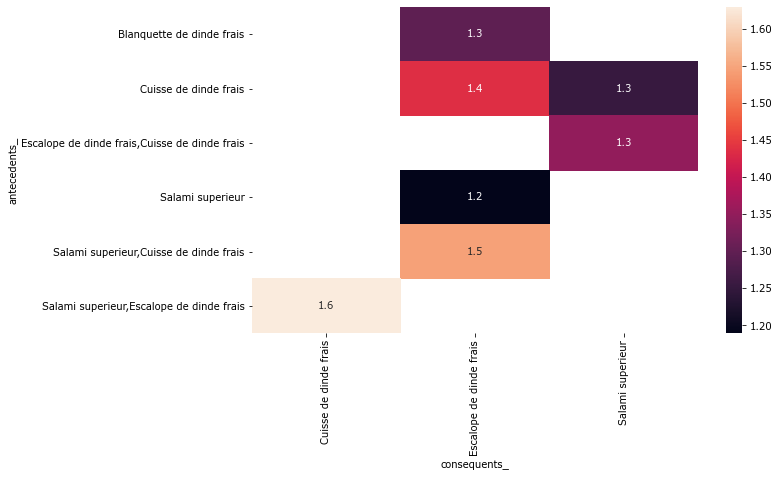

<Figure size 720x432 with 0 Axes>

In [361]:
ar['lhs items'] = ar['antecedents'].apply(lambda x:len(x) )
ar[ar['lhs items']>1].sort_values('lift', ascending=False).head()

import seaborn as sns


# Replace frozen sets with strings
ar['antecedents_'] = ar['antecedents'].apply(lambda a: ','.join(list(a)))
ar['consequents_'] = ar['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = ar[ar['lhs items']>0].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
fig = plt.figure()
fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0.6)

plt.show()